In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.stats import normaltest
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture as GMM
from tqdm import tqdm
from typing import Dict, List, Tuple
from upsetplot import from_contents, UpSet, plot

# Identification of HLA-independent proteolytic fragments in immunopeptidomics data

This notebook is a implemention of the the method proposed by Jens Fritsche and Daniel J. Kowalewski to detect "fake" ligand that were generated as the result of proteolytic degradation (https://doi.org/10.1016/j.mcpro.2021.100110).

In order to identify proteolytic peptides three metrics are computed:
- protein coverage ratio
- HLA ligand propensity
- peptide coverage ratio


## Protein coverage ratio

Protein coverage ratio for protein $P$

$P = \frac{1}{L(P)} \sum_{p \in P}L(p)$

with peptide $p$

where $L(x)$ = Number of amino acids per protein or peptide x 

In [2]:
def proteome_parser(file: str) -> Dict[str, str]:
    """
    Read fasta-format file, returns dict of form scaffold:sequence.
    Note: Uses only the unique identifier of each sequence, rather than the 
    entire header, for dict keys. 
    """
    proteome_dict = {}
    uniprot_id = ''
    sequence = []
    for line in open(file):
        if line.startswith(">") and uniprot_id == '':
            uniprot_id = line.split("|")[1]
        elif line.startswith(">") and uniprot_id != '':
            proteome_dict[uniprot_id] = ''.join(sequence)
            uniprot_id = line.split('|')[1]
            sequence = []
        else:
            sequence.append(line.rstrip())
    proteome_dict[uniprot_id] = ''.join(sequence)
    
    return proteome_dict

In [3]:
def compute_protein_coverage_ratio(df: pd.DataFrame, uniprot_ref_dict: Dict[str, str]) -> pd.DataFrame:
    protein_IDs = []
    protein_coverages = []
    for protein, protein_group in df.groupby("Uniprot"):
        L_peps = []
        for peptide, peptide_group in protein_group.groupby(["sequence"]):
            peps = list(peptide_group["sequence"])
            aa_per_peptide = len(''.join(peps))
            L = aa_per_peptide / len(peps)
            L_peps.append(L)
    
        protein_coverage = 1 / len(uniprot_ref_dict[protein]) * sum(L_peps)
        protein_IDs.append(protein)
        protein_coverages.append(protein_coverage)
    
    protein_coverage_df = pd.DataFrame([protein_IDs,protein_coverages], index=["Uniprot","protein_coverage_ratio"]).T
    return protein_coverage_df

In [4]:
# read input file
df_peptides = pd.read_csv("../data/liegand_input.tsv", sep='\t')

In [5]:
# read reference proteome
uniprot_ref_dict = proteome_parser('../data/spHUMANwoi_201014.fasta')

In [6]:
# split the input dataframe into timsTOF and orbitrap data
df_orbitrap = df_peptides[df_peptides["Sample"].str.contains("orbitrap")]
df_timstof = df_peptides[df_peptides["Sample"].str.contains("timsTOF")]

In [8]:
# compute the protein coverage ratio
#timsTOF
timstof_protein_coverage_ratio = compute_protein_coverage_ratio(df_timstof, uniprot_ref_dict)

#orbitrap
orbitrap_protein_coverage_ratio = compute_protein_coverage_ratio(df_orbitrap, uniprot_ref_dict)

# both
all_protein_coverage_ratio = compute_protein_coverage_ratio(df_peptides, uniprot_ref_dict)

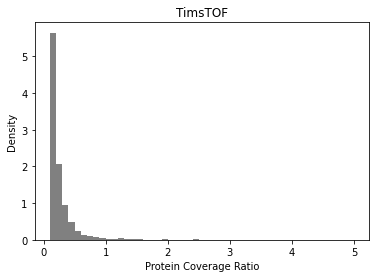

In [9]:
plt.hist(timstof_protein_coverage_ratio["protein_coverage_ratio"], bins=np.linspace(0.1,5), facecolor='gray', density=True);
plt.xlabel('Protein Coverage Ratio')
plt.ylabel('Density')
plt.title('TimsTOF');

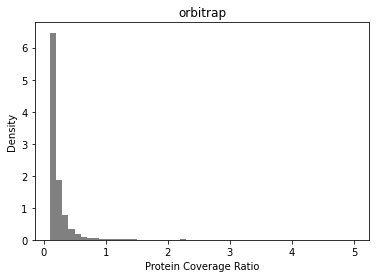

In [10]:
plt.hist(orbitrap_protein_coverage_ratio["protein_coverage_ratio"], bins=np.linspace(0.1,5), facecolor='gray', density=True);
plt.xlabel('Protein Coverage Ratio')
plt.ylabel('Density')
plt.title('orbitrap');

In [11]:
df_peptides_protcov = pd.merge(df_peptides, all_protein_coverage_ratio, on="Uniprot")

## HLA ligand propensity

HLA ligand propensity of peptide $p = \frac{1}{card(S)}\sum_{s \in S}min_{h \in H(s)}Rank(p,h)$ 

with:

sample $s$ in dataset $S$

allele $h$ in all six $H$

peptide $p$

where card is the cardinality (size) of the dataset S

In [12]:
df_orbitrap = df_peptides_protcov[df_peptides_protcov["Sample"].str.contains("orbitrap")]
df_timstof = df_peptides_protcov[df_peptides_protcov["Sample"].str.contains("timsTOF")]

In [13]:
def compute_ligand_propensity(df: pd.DataFrame) -> pd.DataFrame:
    min_ranks = {}
    for sample, sample_group in df.groupby("Sample"):
        for peptide, peptide_group in sample_group.groupby("sequence"):
            min_rank = min(peptide_group["best score_netmhcpan-4.1"])
            if peptide not in min_ranks:
                min_ranks.update({peptide: [min_rank]})
            else:
                min_ranks[peptide].append(min_rank)
                
    peptide_propensities = {peptide: sum(min_rank)/len(min_rank) for peptide, min_rank in min_ranks.items()}
    peptide_propensities_df = pd.DataFrame.from_dict(peptide_propensities.items())  \
                                      .rename(columns={0:"sequence",1:"propensity"})
    return peptide_propensities_df

In [14]:
timstof_ligand_propensity = compute_ligand_propensity(df_timstof)
orbitrap_ligand_propensity = compute_ligand_propensity(df_orbitrap)
all_ligand_propensity = compute_ligand_propensity(df_peptides_protcov)

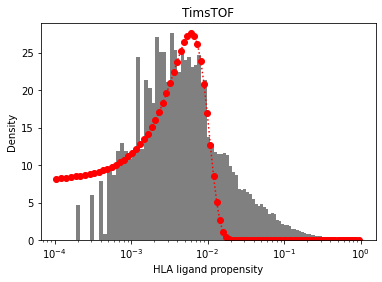

In [16]:
tp = plt.hist(timstof_ligand_propensity["propensity"], bins=np.power(np.linspace(0.4, 1, 100), 10), facecolor='gray', density=True)
plt.xscale('log')
plt.xlabel('HLA ligand propensity')
plt.ylabel('Density')
plt.title('TimsTOF');

x = tp[1][:-1]
y = tp[0]

n = len(x)
mean = sum(x * y) / n
sigma = sum(y * (x - mean) ** 2) / n


def gaus(x: float, a: float, x0: float, sigma: float) -> float:
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

popt, pcov = curve_fit(gaus, x, y, p0=[1, mean, sigma])

plt.plot(x, gaus(x, *popt), 'ro:', label='fit')

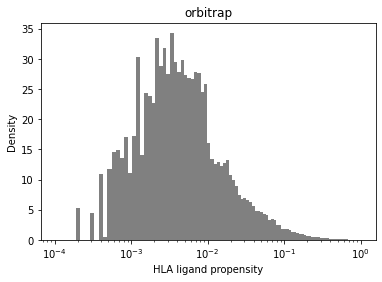

In [17]:
lp = plt.hist(orbitrap_ligand_propensity["propensity"], bins=np.power(np.linspace(0.4,1, 100), 10), facecolor='gray',density=True)
plt.xscale('log')
plt.xlabel('HLA ligand propensity')
plt.ylabel('Density')
plt.title('orbitrap');

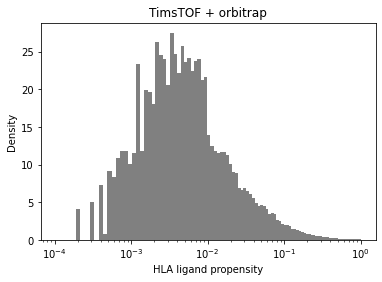

In [18]:
ip = plt.hist(all_ligand_propensity["propensity"], bins=np.power(np.linspace(0.4,1, 100), 10), facecolor='gray',density=True)
plt.xscale('log')
plt.xlabel('HLA ligand propensity')
plt.ylabel('Density')
plt.title('TimsTOF + orbitrap');

In [19]:
df_peptides_protcov_propensity = pd.merge(df_peptides_protcov, all_ligand_propensity, on="sequence")

## Peptide coverage ratio

peptide coverage ratio for peptide $p = \frac{1}{card(S)} \sum_{s \in S}  \left(  \frac{1}{L(P)} \sum_{\textit{q overlaps with p in s}} L(q) \right)$ 

with:

$q$ overlaps

where card is the cardinality (size) of the dataset S and sample $s$ in the dataset

where $L(x)$ = Number of amino acids per protein or peptide x 

In [20]:
def generate_uniprot_pept_dict(df: pd.DataFrame, sample_keyword: str) -> Dict[str, Dict[str, List]]:
    """
    In order to fascilate the computation of the peptide coverage ratio, the information about all the peptides in one samples originating from the sample protein is required.
    This function generates a hierarchical dictionary with the uniprot ID on the first level and the sample IDs on the second level:
    
    Example:
    {'uniprot_id_1': {'sample_id_1': ['peptide_seq_1', 'peptide_seq_2', ... , peptide_seq_x],
                      'sample_id_2': ['peptide_seq_3', 'peptide_seq_4', ... , peptide_seq_y],
                      ...
                      'sample_id_i': ['peptide_seq_5', 'peptide_seq_6', ... , peptide_seq_z]},              
     'uniprot_id_2': {'sample_id_1': ['peptide_seq_1', 'peptide_seq_2', ... , peptide_seq_x],
                      'sample_id_2': ['peptide_seq_3', 'peptide_seq_4', ... , peptide_seq_y],
                      ...
                      'sample_id_i': ['peptide_seq_5', 'peptide_seq_6', ... , peptide_seq_z]},
    ...
    'uniprot_id_xxx': {...}}
    
    """
    
    uniprot_sample_peptide_dict = {}
    for sequence, uniprot_id, sample  in zip(df['sequence'], df['Uniprot'], df['Sample']):
        if sample_keyword in sample:
            if uniprot_id not in uniprot_sample_peptide_dict.keys():
                uniprot_sample_peptide_dict[uniprot_id] = {}
            
            if sample not in uniprot_sample_peptide_dict[uniprot_id].keys():
                uniprot_sample_peptide_dict[uniprot_id][sample] = []
            uniprot_sample_peptide_dict[uniprot_id][sample].append(sequence)
     
    return uniprot_sample_peptide_dict

In [21]:
def compute_peptide_coverage(peptide_list: List[str], protein_seq: str, protein_name: str) ->  Dict[str, float]:
    """
    To compute the overlaps of peptides at each position in the protein, first the sum of the coverage of each postion is calculated.
    Then for each peptide the sum of the coverage values of its mapping positions in the protein is taken and devided by peptide length.
    
    If there are no overlaps of a peptide with another one, this will result in a score of 1.
    
    """ 
    peptide_coverage_dict = {}
    protein_freq_array = [0] * len(protein_seq) # a zero array is generated representing a the protein. Each position in the array holds information about the mapping coverage the respective position.
    
    all_peptides_matches = []
    for peptide in peptide_list:
        petides_matches = [m.start() for m in re.finditer('(?=' + peptide + ')', protein_seq)] # find match position of peptide in protein sequence
        all_peptides_matches.append(petides_matches)
        if len(petides_matches) >= 2: # if a peptide matches multiple time in a protein, it is excluded. In the case repetitive sequences, the score can be heavily skewed (e.g. EEEEEEEE)  
            pass
        for match_idx in petides_matches:
            for i in range(match_idx, len(peptide) + match_idx):
                protein_freq_array[i] += 1
    
    for peptide, petides_matches in zip(peptide_list, all_peptides_matches):
        all_overlaps = []
        for match_idx in [petides_matches[0]]: # for each start index (multimappers in the same protein) -currently only the first hit is taken
            overlaps = 0
            for i in range(match_idx, len(peptide) + match_idx):
                overlaps += protein_freq_array[i]
            all_overlaps.append(overlaps)
        
        max_overlaps = max(all_overlaps) # if there is a peptide mapping to multiple positions in the same protein, the highest number of overlaps are taken
            
        sample_peptide_coverage = max_overlaps / len(peptide)
        peptide_coverage_dict[peptide] = sample_peptide_coverage
    
    return peptide_coverage_dict

In [22]:
#peptide_coverage_all_samples
def average_coverage_ratio(peptide_coverage_all_samples: List[Dict[str, float]], peptide_sample_count: Dict[str, int], uniprot_id: str) -> Dict[Tuple[str, str], float]:
    """
    computes the average peptide coverage ratio
    """
    overlap_coverage_sums = {}
    for sample_peptide_coverage in peptide_coverage_all_samples:
        for sequence, coverage in sample_peptide_coverage.items():
            if sequence not in overlap_coverage_sums.keys():
                overlap_coverage_sums[sequence] = 0
            overlap_coverage_sums[sequence] += coverage

    overlap_coverage_ratios = {}
    for sequence, coverage_sum in overlap_coverage_sums.items():
        overlap_coverage_ratios[(uniprot_id, sequence)] = coverage_sum / peptide_sample_count[sequence]
        
    return overlap_coverage_ratios

In [23]:
def get_prot_pep_coverage_ratio(all_uniprot_entries: Dict[str, List[str]], uniprot_sample_peptide_dict: Dict[str, Dict[str, List[str]]]) -> pd.DataFrame:
    """
    main function for calculating the peptide coverage ratio, calls helper functions
    """                                                                                                     
    protein_peptide_coverage_ratio = {}
    for uniprot_id, samples_dict in tqdm(uniprot_sample_peptide_dict.items()):
        protein_sequence = all_uniprot_entries[uniprot_id]
        peptide_coverage_all_samples = []

        # count samples containing each peptides
        peptide_sample_count = {} # "peptide_seq" : number of samples in which this peptide was measured

        for sample_name, peptide_list in samples_dict.items():
            peptide_list = list(set(peptide_list))
            peptide_coverage_dict = compute_peptide_coverage(peptide_list, protein_sequence, uniprot_id)
            peptide_coverage_all_samples.append(peptide_coverage_dict)

            for sequence in set(peptide_list):
                if sequence not in peptide_sample_count.keys():
                    peptide_sample_count[sequence] = 0
                peptide_sample_count[sequence] += 1

        coverage_ratio_protein = average_coverage_ratio(peptide_coverage_all_samples, peptide_sample_count, uniprot_id)

        protein_peptide_coverage_ratio |= coverage_ratio_protein
    
    data = []
    for protein_sequence_tuple, peptide_coverage_ratio in protein_peptide_coverage_ratio.items():
        uniprot = protein_sequence_tuple[0]
        sequence = protein_sequence_tuple[1]
        data.append([uniprot, sequence, peptide_coverage_ratio])
    df = pd.DataFrame(data=data, columns=["Uniprot", "sequence", "peptide_coverage_ratio"])
    
    return df

In [24]:
# prepare nested dict for computation of the score
# Dict[str, Dict[str, List]]
uniprot_sample_peptide_dict_all = generate_uniprot_pept_dict(df_peptides_protcov_propensity, "")

In [25]:
# compute the peptide coverage ratio
protein_peptide_coverage_ratio_all = get_prot_pep_coverage_ratio(uniprot_ref_dict, uniprot_sample_peptide_dict_all)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12197/12197 [00:06<00:00, 2017.79it/s]


In [26]:
# merge the peptide coverage to the results dataframe
df_peptides_protcov_propensity_peptcov = pd.merge(df_peptides_protcov_propensity, protein_peptide_coverage_ratio_all, on=["Uniprot", "sequence"])

In [27]:
# write file to csv
df_peptides_protcov_propensity_peptcov.to_csv("../data/test_out.csv")

# Expectation maximization
This approach can be used to distinguish two mixture gaussian distributions from each other that partially overlap. The discrimimation of those two distributions can be done by the EM algorithm, which performs a soft clustering approach maximizing the log-likelihood that the discriminanted clusters belong to the right cluster

See also: https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

### Threshold finding for the peptide coverage ratio score

In [28]:
df_peptcov_em = df_peptides_protcov_propensity_peptcov[["sequence", "Uniprot", "peptide_coverage_ratio"]]

In [29]:
all_coverage_ratio_values = [x for x in df_peptcov_em['peptide_coverage_ratio'] if x != 1.0] # drop peptides without any overlaps

In [30]:
all_coverage_ratio_values_reshaped = np.array(all_coverage_ratio_values).reshape(-1, 1)

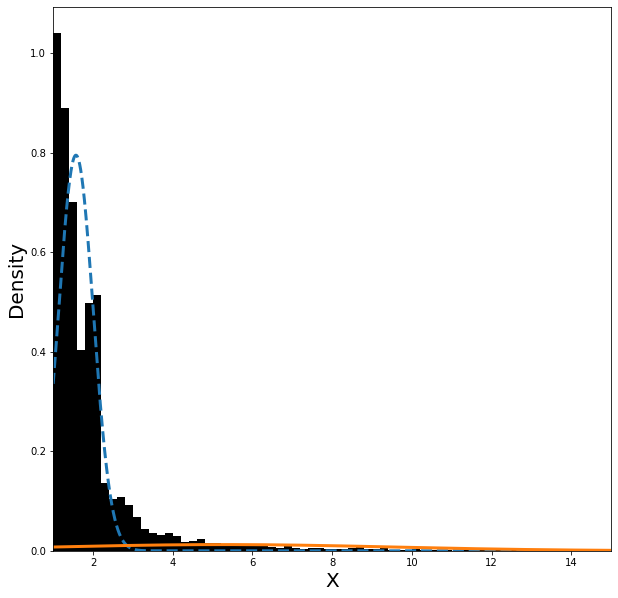

In [31]:
fig = plt.figure(figsize=(10, 10))

n_optimal = 2

# create GMM model object
gmm = GMM(n_components = n_optimal, max_iter=1000, random_state=100, covariance_type = 'full')

# find useful parameters
mean = gmm.fit(all_coverage_ratio_values_reshaped).means_  
covs  = gmm.fit(all_coverage_ratio_values_reshaped).covariances_
weights = gmm.fit(all_coverage_ratio_values_reshaped).weights_

# create necessary things to plot
x_axis = np.arange(-1, 15, 0.001)
y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

plt.hist(all_coverage_ratio_values_reshaped, density=True, color='black', bins=np.arange(1.0, 15, 0.2))
plt.plot(x_axis, y_axis0, lw=3, c='C0', ls='dashed')
plt.plot(x_axis, y_axis1, lw=3, c='C1')
plt.xlim(1, 15)
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)

plt.subplots_adjust(wspace=0.3)
plt.show()
plt.close('all')

In [32]:
fdr = 0.05

y_true_sum = 0
y_false_sum = 0
left_probabilities = []
x_values = []

threshold = 1 - fdr
previous_over_threshold = False

for y_true, y_false, x in zip(y_axis0, y_axis1, x_axis):
    y_true_sum += y_true
    y_false_sum += y_false
    
    if (y_true_sum + y_false_sum) != 0:
        if x >= 1:
            left_probability = y_true_sum / (y_true_sum + y_false_sum)
            left_probabilities.append(y_true_sum / (y_true_sum + y_false_sum))
            x_values.append(x)
            
            if previous_over_threshold and threshold > left_probability:
                pept_cov_threshold = x
                print(f'Threshold value peptide coverage ratio: {pept_cov_threshold}')
            
            if left_probability >= threshold:
                previous_over_threshold = True
            else:
                previous_over_threshold = False

Threshold value peptide coverage ratio: 4.310000000000005


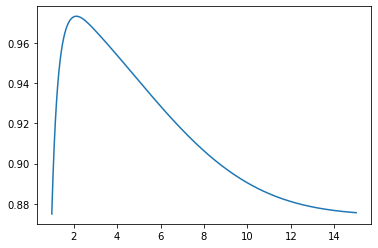

In [33]:
plt.plot(x_values, left_probabilities)

In [34]:
def estimation_maximation(coverage_ratio: List[float], fdr: float) -> float: 
    x = np.asarray(coverage_ratio).reshape(-1, 1)

    gmm = GMM(n_components = 2, max_iter=500, random_state=10, covariance_type = 'full')

    # find useful parameters
    mean = gmm.fit(x).means_  
    covs  = gmm.fit(x).covariances_
    weights = gmm.fit(x).weights_

    # create necessary things to plot
    x_axis = np.arange(min(coverage_ratio), max(coverage_ratio), 0.00001)
    y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
    y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

    # Plot 2
    plt.figure(figsize=(10, 8))
    plt.hist(x, density=True, color='black', bins=np.linspace(0.1,2,500))
    plt.plot(x_axis, y_axis0, lw=3, c='C0')
    plt.plot(x_axis, y_axis1, lw=3, c='C1')
    plt.plot(x_axis, y_axis0+y_axis1, lw=3, c='C2', ls='dashed')
    plt.xlim(0, 4)

    plt.xlabel(r"X", fontsize=20)
    plt.ylabel(r"Density", fontsize=20)

    plt.show()
    plt.close('all')
    
    y_true_sum = 0
    y_false_sum = 0
    left_probability = []
    x_values = []
    for y_true, y_false, x in zip(y_axis0, y_axis1, x_axis):
        y_true_sum += y_true
        y_false_sum += y_false
    
        if (y_true_sum + y_false_sum) != 0:
            left_probability.append(y_true_sum / (y_true_sum + y_false_sum))
            x_values.append(x)

    plt.plot(x_values, left_probability)
    
    y_max = 0
    x_max = 0
    for x, y in zip(x_values, left_probability):
        if 1 - y > 0.05:
            break
        else:
            y_max = y
            x_max = x
    threshold = x_max
    print(f'Threshold: {x_max}')
    return x_max

### Protein coverage ratio

In [35]:
fdr = 0.05 # false discovery rate

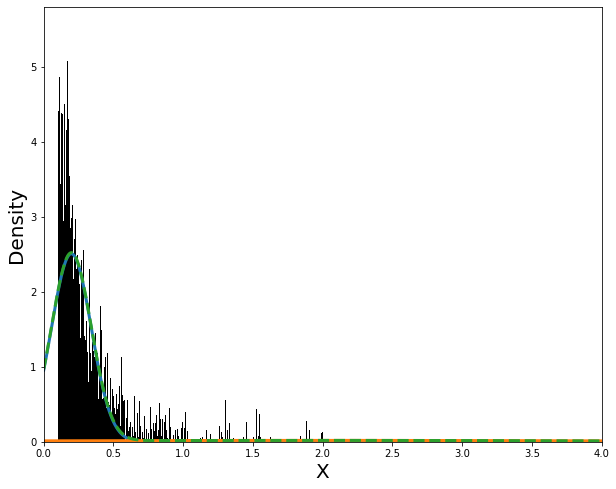

Threshold: 2.5447527480916095


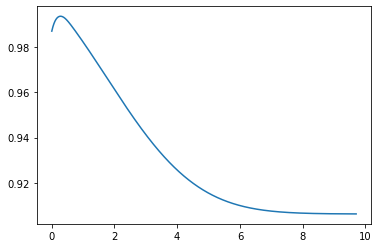

In [36]:
threshold_protein_coverage_ratio = estimation_maximation(df_peptides_protcov_propensity_peptcov["protein_coverage_ratio"], fdr)

### Propensity

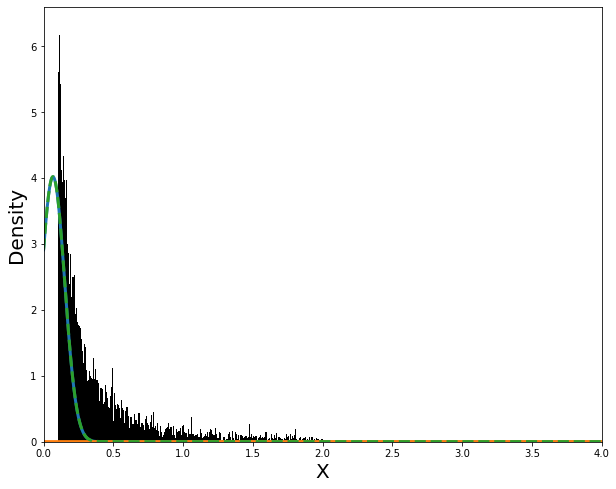

Threshold: 11.705029999999999


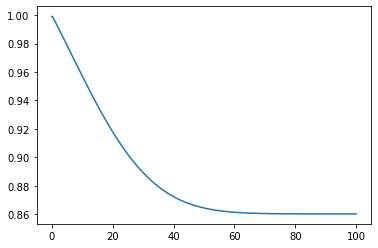

In [37]:
threshold_propensity = estimation_maximation(df_peptides_protcov_propensity_peptcov["propensity"], fdr)

## Proteolytic Contamination Count (PCC)

$ 
\textit{PCC} = 
\left\{ 
  \begin{array}{ c l }
    1 & \quad \textrm{if } \textrm{protein coverage ratio} > \textrm{threshold value} \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right\}
+
\left\{ 
  \begin{array}{ c l }
    1 & \quad \textrm{if } \textrm{peptide coverage ratio} > \textrm{threshold value} \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right\}
+
\left\{ 
  \begin{array}{ c l }
    1 & \quad \textrm{if } \textrm{HLA ligand propensity} > \textrm{threshold value} \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right\}
$

In [38]:
def predict_proteolytic_peptides(row):
    return sum([row["pcc_prot_cov"], row["pcc_pept_cov"], row["pcc_prop"]]) >= 2

In [39]:
df_peptides_protcov_propensity_peptcov["pcc_prot_cov"] = np.where(df_peptides_protcov_propensity_peptcov['protein_coverage_ratio'] > threshold_protein_coverage_ratio, 1, 0)
df_peptides_protcov_propensity_peptcov["pcc_pept_cov"] = np.where(df_peptides_protcov_propensity_peptcov['peptide_coverage_ratio'] > pept_cov_threshold, 1, 0)
df_peptides_protcov_propensity_peptcov["pcc_prop"] = np.where(df_peptides_protcov_propensity_peptcov['propensity'] > threshold_propensity, 1, 0)
df_peptides_protcov_propensity_peptcov["is_proteolytic"] = df_peptides_protcov_propensity_peptcov.apply(predict_proteolytic_peptides, axis=1)

In [40]:
timstof_liegands = df_peptides_protcov_propensity_peptcov[df_peptides_protcov_propensity_peptcov["Sample"].str.contains("timsTOF")]
orbitrap_liegands = df_peptides_protcov_propensity_peptcov[df_peptides_protcov_propensity_peptcov["Sample"].str.contains("orbitrap")]

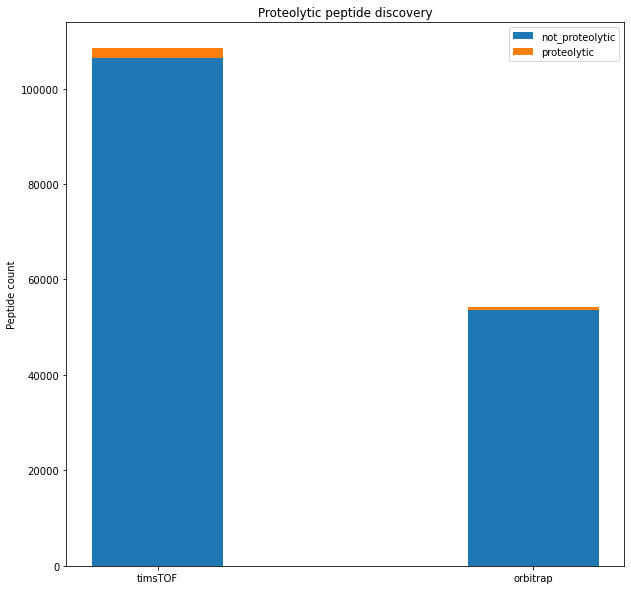

In [41]:
labels = ['timsTOF', 'orbitrap']
proteolytic  = [sum(timstof_liegands["is_proteolytic"]), sum(orbitrap_liegands["is_proteolytic"])]
not_proteolytic = [sum(timstof_liegands["is_proteolytic"] == False), sum(orbitrap_liegands["is_proteolytic"] == False)]

width = 0.35   
fig, ax = plt.subplots(figsize=(10,10))

ax.bar(labels, not_proteolytic, width, label='not_proteolytic')
ax.bar(labels, proteolytic, width, bottom=not_proteolytic,
       label='proteolytic')

ax.set_ylabel('Peptide count')
ax.set_title('Proteolytic peptide discovery')
ax.legend()

plt.show()

In [42]:
print("timsTOF proteolytic: {0} %".format((proteolytic[0] / (proteolytic[0] + not_proteolytic[0])) * 100)) 

timsTOF proteolytic: 1.9651943072044833 %


In [43]:
print("orbitrap proteolytic: {0} %".format((proteolytic[1] / (proteolytic[1] + not_proteolytic[1])) * 100)) 

orbitrap proteolytic: 0.869966752862948 %


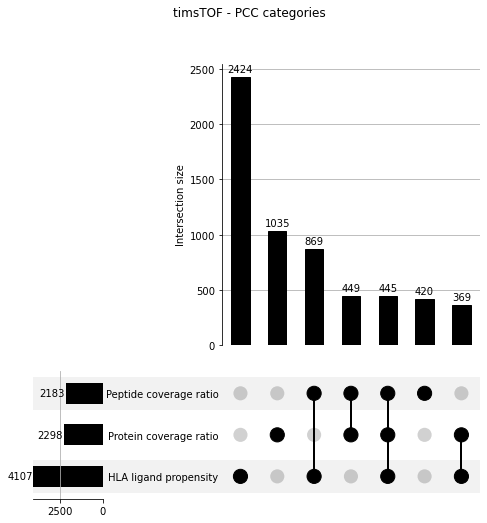

In [44]:
fig = plt.figure(figsize=(8, 8))

pcc = from_contents({'Protein coverage ratio': timstof_liegands[timstof_liegands['pcc_prot_cov'] == 1].index.tolist(),
                     'Peptide coverage ratio': timstof_liegands[timstof_liegands['pcc_pept_cov'] == 1].index.tolist(),
                     'HLA ligand propensity': timstof_liegands[timstof_liegands['pcc_prop'] == 1].index.tolist()
                    })

plot(pcc, fig=fig, element_size=None, show_counts=True, sort_by='cardinality')
plt.suptitle('timsTOF - PCC categories')
plt.show()

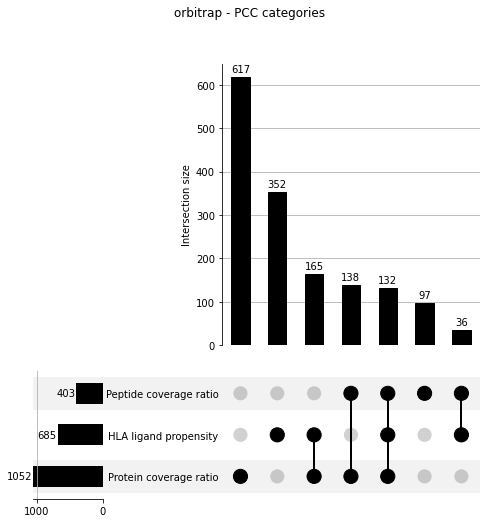

In [45]:
fig = plt.figure(figsize=(8, 8))

pcc = from_contents({'Protein coverage ratio': orbitrap_liegands[orbitrap_liegands['pcc_prot_cov'] == 1].index.tolist(),
                     'Peptide coverage ratio': orbitrap_liegands[orbitrap_liegands['pcc_pept_cov'] == 1].index.tolist(),
                     'HLA ligand propensity': orbitrap_liegands[orbitrap_liegands['pcc_prop'] == 1].index.tolist()
                    })

plot(pcc, fig=fig, element_size=None, show_counts=True, sort_by='cardinality')
plt.suptitle('orbitrap - PCC categories')
plt.show()

In [46]:
df_peptides_protcov_propensity_peptcov.to_csv("../data/proteolytic_degradation_output_061222.tsv", sep="\t", index=False)